# Classification binaire supervisée sur pour la cardiopathie

Loïc Rakotoson
------

In [557]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelBinarizer, OrdinalEncoder, OneHotEncoder, MinMaxScaler, Binarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import f1_score, recall_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

<hr>

### Annexes

In [356]:
class IsTop(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.top = list()
        
    def input(self, X):
        if isinstance(X, pd.DataFrame):
            X_ = X.to_numpy().copy()
        else: X_ = X.copy()
        return X_.astype(np.float).astype(np.int)
    
    def fit(self, X, y = None):
        X_ = self.input(X)
        for i in range(X_.shape[1]):
            self.top.append(np.bincount(X_[:,i]).argmax())
            
    def transform(self, X, y = None):
        X_ = self.input(X)
        for i in range(X_.shape[1]):
            X_[:,i] = X_[:,i] == self.top[i]
        X[X.columns] = X_
        return X
    
    def fit_transform(self, X, y = None):
        X_ = self.input(X)
        for i in range(X_.shape[1]):
            top = np.bincount(X_[:,i]).argmax()
            self.top.append(top)
            X_[:,i] = X_[:,i] == top
        X[X.columns] = X_
        return X

In [442]:
class LessFrequent(BaseEstimator, TransformerMixin):
    def __init__(self, missing = np.nan):
        self.missing = missing
        self.less = None
    
    def input(self, X):
        if isinstance(X, pd.DataFrame):
            X_ = X.to_numpy().copy().reshape((-1,))
        else: X_ = X.copy().reshape((-1,))
        return X_.astype(np.float).astype(np.int)
    
    def fit(self, X, y = None):
        X_ = self.input(X)
        self.less = np.bincount(X_).argmin()
        
    def transform(self, X, y = None):
        column = X.columns
        X_ = self.input(X)
        X = X.drop(column, axis = 1)
        X[column] = np.where(
            X_ == self.less, self.missing, X_
        ).astype(np.float).reshape((-1,1))
        return X
    
    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)

In [455]:
class Calibrate(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return (X < self.threshold).astype(np.int)
    
    def fit_transform(self, X, y = None):
        return self.transform(X)

In [6]:
def gather( df, key, value, cols ):
    id_vars = [ col for col in df.columns if col not in cols ]
    id_values = cols
    var_name = key
    value_name = value
    return pd.melt( df, id_vars, id_values, var_name, value_name)

In [525]:
def get_feature_names(column_transformer):
    def get_names(trans):
        if trans == 'drop' or (hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
            warnings.warn("Transformer %s (type %s) does not "
                          "provide get_feature_names. "
                          "Will return input column names if available" %
                          (str(name), type(trans).__name__))
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]
        return [name + "__" + f for f in trans.get_feature_names()]

    feature_names = []
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None)
                          for step, name, trans in column_transformer._iter()]
    else:
        l_transformers = list(column_transformer._iter(fitted=True))
    for name, trans, column, _ in l_transformers:
        if type(trans) == Pipeline:
            _names = get_feature_names(trans)
            if len(_names) == 0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))

    return feature_names

In [647]:
def nestedCV(estimator, param_grid, x_train, y_train, inner_cv, outer_cv,
             **kwargs):
    n_jobs = kwargs.get('n_jobs', -1)
    scoring = kwargs.get('scoring', 'f1')
    name = kwargs.get('name')
    results = list()
    x_train = x_train.reset_index(drop=True)

    for train, val in outer_cv.split(x_train, y_train):
        search = GridSearchCV(estimator,
                              param_grid,
                              cv=inner_cv,
                              scoring=scoring,
                              n_jobs=n_jobs,
                              refit=True).fit(x_train.iloc[train, :],
                                              y_train[train])
        y_pred = search.predict(x_train.iloc[val, :])
        result = search.best_params_
        result['name'] = name
        result['f1_score'] = f1_score(y_train[val], y_pred)
        result['inner_score'] = search.best_score_
        result['recall'] = recall_score(y_train[val], y_pred)
        result['accuracy'] = accuracy_score(y_train[val], y_pred)
        results.append(result)

    aggregate = pd.DataFrame(results).groupby(list(param_grid.keys()) +
                                              ['name'],
                                              as_index=False)
    table = aggregate.mean()
    table['count'] = aggregate.count().f1_score

    best_params = {
        k: v
        for k, v in table.sort_values(
            ['f1_score'], ascending=False).iloc[0].to_dict().items()
        if k in param_grid.keys()
    }

    return table, best_params

<hr>

# Introduction

Dans ce document nous cherchons à effectuer une classification supervisée pour prédire la présence de cardiopathie en fonctions de plusieurs mesures effectuées sur les patients.  
Dans la suite, les modèles de classifications seront optimisés par rapport au score F1 et au Rappel. Ce choix s'explique par les contreparties des mauvaises prédictions. En effet, il serait plus toléré d'avoir des faux positifs que des patients malades non détectés. A performance F1 égale, le Rappel permettra de trancher entre deux algorithmes.

Lors de l'import des données, les types données par la documentation ont été gardés. Cependant, certaines variables numériques ont été directement discrétisées en se basant sur leur déscription dans la même documentation.  
Ci-dessous les permières lignes de nos données.

In [5]:
data = (
    pd.read_csv(
        'heart.dat', header=None, sep='\s+', engine='python',
        dtype={
            0: np.int, 1: 'category', 2: 'category',
            3: np.int, 4: np.float, 5: np.bool,
            6: 'category', 7: np.int, 8: np.bool,
            9: np.float, 10: 'category', 11: 'category',
            12: 'category', 13: 'category'
        }
    ).rename(columns={
        0: "age", 1: "sex", 2: "chest_pain",
        3: "blood_pressure", 4: "cholesterol",
        5: "blood_sugar", 6: "electrocard",
        7: "heart_rate", 8: "angina", 9: "oldpeak",
        10: "slope_peak", 11: "vessels", 12: "thal",
        13: "target"
    })
)

,age,sex,chest_pain,blood_pressure,cholesterol,blood_sugar,electrocard,heart_rate,angina,oldpeak,slope_peak,vessels,thal,target
0,70,1.0,4.0,130,322.0,False,2.0,109,False,2.4,2.0,3.0,3.0,2
1,67,0.0,3.0,115,564.0,False,2.0,160,False,1.6,2.0,0.0,7.0,1
2,57,1.0,2.0,124,261.0,False,0.0,141,False,0.3,1.0,0.0,7.0,2
3,64,1.0,4.0,128,263.0,False,0.0,105,True,0.2,2.0,1.0,7.0,1
4,74,0.0,2.0,120,269.0,False,2.0,121,True,0.2,1.0,1.0,3.0,1


# Analyse exploratoire des données

Pour effectuer l'analyse, des groupes de colonnes ont été crées en fonction de leur type.

Le but de cette analyse est de comprendre les données et tirer des informations, notamment les distribution, les corrélations et les covariances.

In [470]:
numerical = data.select_dtypes([np.int, np.float]).columns.to_list()
boolean = data.select_dtypes(np.bool).columns.to_list()
categorical = data.select_dtypes([np.bool, 'category']).columns.to_list()[:-1]
ordinal = [data.columns[2], data.columns[10]]

## Analyse de la target

Nous avons une variable cible binaire (`1`: absence et `2`: présence de cardiopathie).  
Nous ne faisons pas façe à une variable désiquilibrée, donc il n'y aura pas besoin d'effectuer des stratégies d'over-under-sampling.

D:\Programmes\Anaconda3\envs\datascience\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


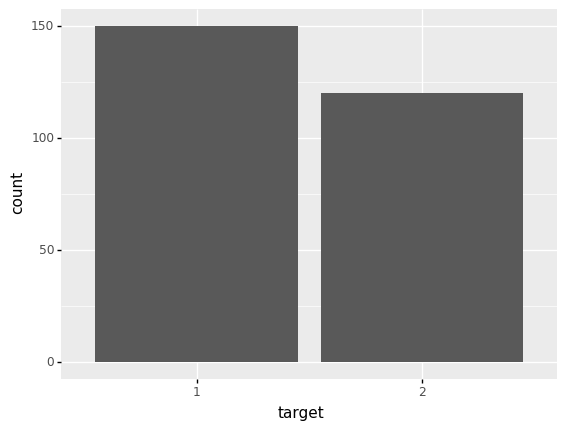

<ggplot: (-9223371917936602816)>

In [5]:
(ggplot(data) + aes("target") + geom_bar())

## Analyse des variables qualitatives

- Chaque modalité de la variable `blood_sugar` possède sensiblement la même distribution de target. Elle ne fait pas varier la target.
- La distribution de la target dans vessels est la même quand elle est présente. On peut la transformer en variable binaire de présence ou non. On observe le même phénomène avec `chest_pain` où la modalité `4` se démarque des autres qui distribuent de la même manière la target.
- Il n'existe que 2 personnes avec la modalité `1` de la variable `electrocard` dont l'une est positive à la target. Cette modalité n'a pas de variance. Par contre la modalité `0` semble discriminer la target. Si la variable electrocard est utilisée, on pourra la convertir en binaire en imputant la modalité `1` et en assignant l'individu à l'une des des autres modalité grâce à un algorithmes de plus proches voisins ou par une méthode de moyenne par exemple.

D:\Programmes\Anaconda3\envs\datascience\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


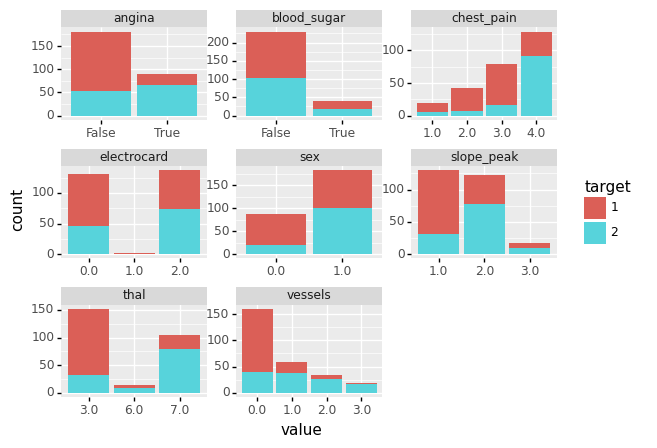

<ggplot: (-9223371917929555512)>

In [6]:
(
    data[categorical+["target"]]
    .pipe(gather, "key", "value", categorical)
    .pipe(ggplot) + aes(x = "value", fill = "target") +
    geom_bar() + theme(subplots_adjust={'wspace':.2, 'hspace':.5}) +
    facet_wrap("~key", scales = "free")
)

## Analyse des variables quantitatives

- Les variables `blood_presure` et `cholesterol` sont chacun sensiblement distribuées de la même façon par rapport à la target, mais avec léger décalage.
- L'`age`, le `heart_rate` et `oldpeak` possèdent une distribution différente pour chaque modalité de la target
- La variable `oldpeak` possède plusieurs outliers et on remarque d'ailleurs un écart significatif entre les moyennes et les médianes pour chacune des modalités de la target. On préfèrera centrer cette variable sur la médiane et la réduire entre la 1re et la 3e quartile.

In [7]:
data.describe()

,age,blood_pressure,cholesterol,heart_rate,oldpeak
count,270.000000,270.000000,270.000000,270.000000,270.00000
mean,54.433333,131.344444,249.659259,149.677778,1.05000
std,9.109067,17.861608,51.686237,23.165717,1.14521
min,29.000000,94.000000,126.000000,71.000000,0.00000
25%,48.000000,120.000000,213.000000,133.000000,0.00000
50%,55.000000,130.000000,245.000000,153.500000,0.80000
75%,61.000000,140.000000,280.000000,166.000000,1.60000
max,77.000000,200.000000,564.000000,202.000000,6.20000


D:\Programmes\Anaconda3\envs\datascience\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
D:\Programmes\Anaconda3\envs\datascience\lib\site-packages\plotnine\stats\stat_boxplot.py:86: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(data['x']):


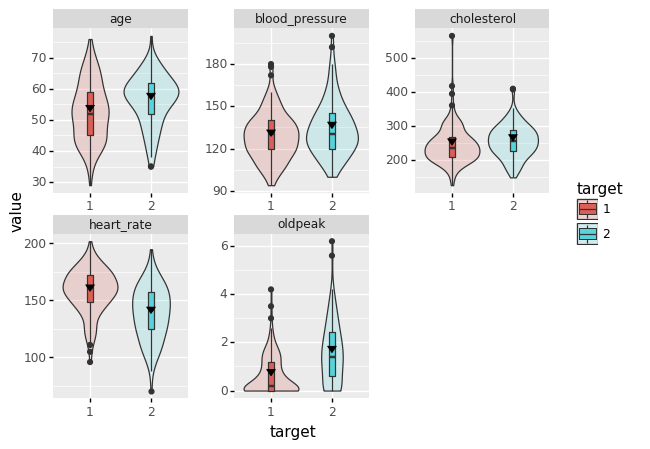

<ggplot: (-9223371917914679184)>

In [32]:
(
    data[numerical+['target']]
    .pipe(gather, "key", "value", numerical)
    .pipe(ggplot) + aes(y = "value", x = "target", fill = "target") +
    geom_violin(alpha = .2) + geom_boxplot(width=0.1) +
    stat_summary(fun_y=np.mean, geom="point", shape=7, size=3, fill = "black") +
    facet_wrap("~key", ncol = 3, scales = "free") +
    theme(subplots_adjust={'wspace':.35, 'hspace':.25})
)

Le graphe ci-après présente les relations variables-variables.  
On notera une certaine correlation négative entre la variable `age` et `heart_rate`.

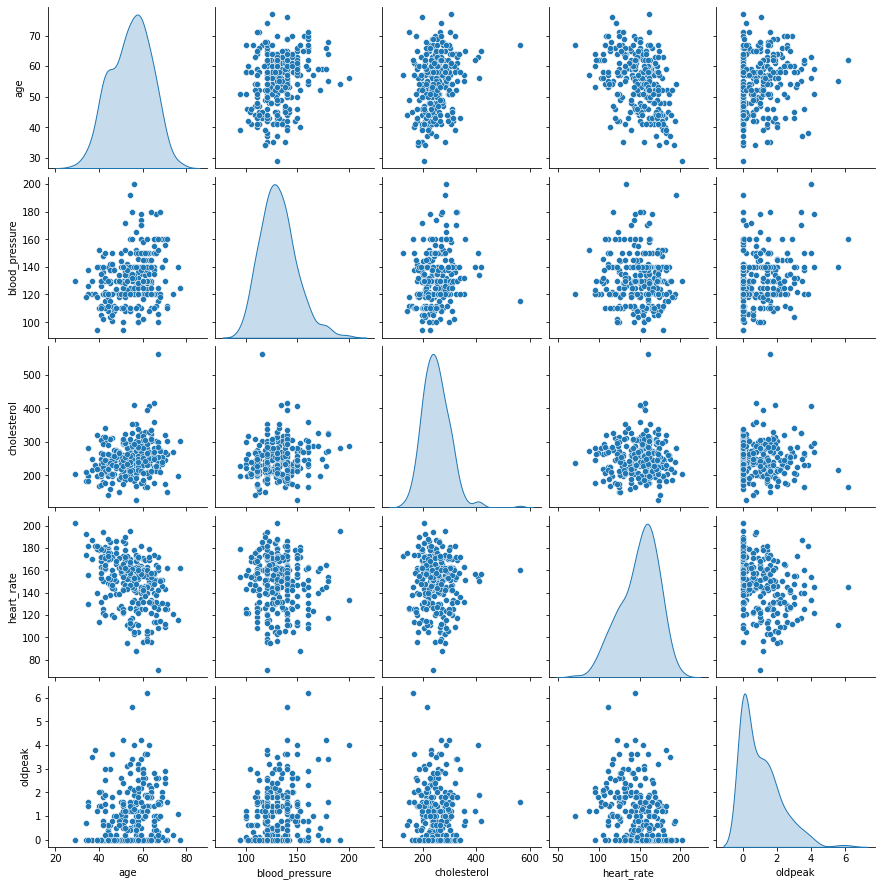

In [9]:
sns.pairplot(data[numerical], diag_kind="kde")
plt.show()

# Pretraitement

En se basant sur l'analyse exploratoire des données, les prétraitements que nous allons effectuer sont les suivants:

- `electrocard`: Affectation de la modalité `1` à l'une des deux autres avec un `KNNImputer` et binarisation
- `vessels` et `chest_pain`: Regroupement des variables en fonction de la façon de distribuer la target et binarisation
- `oldpeak`: standardisation par rapport à la médiane
- variables quantitatifs: standardisation par rapport à la moyenne

In [505]:
electropipe = Pipeline([('ls', LessFrequent()), ('scale', MinMaxScaler()),
                        ('inputer', KNNImputer()),
                        ('calib', Binarizer(threshold=.5))])

preprocess = ColumnTransformer(
    remainder='passthrough',
    transformers=[('inp', electropipe, ['electrocard']),
                  ('topbin', IsTop(), ['vessels', 'chest_pain']),
                  ('bin', Binarizer(), ['angina', 'blood_sugar', 'sex']),
                  ('ordinal', OrdinalEncoder(), ['slope_peak']),
                  ('onehot', OneHotEncoder(drop='first'), ['thal']),
                  ('standard', StandardScaler(), numerical[:-1]),
                  ('scaler', RobustScaler(), ['oldpeak'])])

label = LabelBinarizer()

Les données sont ensuite séparées en sets d'entrainement et de tests.

In [549]:
x_train, x_test = train_test_split(data, test_size=.2, random_state=42069)
y_train = label.fit_transform(x_train.pop('target'))
y_test = label.transform(x_test.pop('target'))

In [543]:
trainset = pd.DataFrame(
    np.hstack([preprocess.fit_transform(x_train), y_train]),
     columns = get_feature_names(preprocess) + ['target']
)

,inp__electrocard,topbin__vessels,topbin__chest_pain,bin__angina,bin__blood_sugar,bin__sex,ordinal__slope_peak,onehot__x0_6.0,onehot__x0_7.0,standard__age,standard__blood_pressure,standard__cholesterol,standard__heart_rate,scaler__oldpeak,target
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.398675,-0.319788,-0.704662,-1.049211,0.3750,0.0
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.345403,-1.757636,0.895558,-1.049211,0.0625,1.0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.161710,-1.182497,-1.002377,1.203224,-0.5000,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.364359,0.312865,1.267702,0.120322,-0.5000,1.0
4,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,-0.725690,-1.182497,-0.406946,0.813379,0.1250,1.0


# Modelisation
## Benchmark Naif

Dans la suite nous allons effectuer un benchmark naif des modèles classiques utilisés pour la classification binaire.  
Nous capturerons comme score le f1, le recall et l'accuracy.

Nous choisions d'optimiser les 3 premiers algorithmes ainsi qu'Adaboost qui se démarque avec un bon score recall malgré le f1 assez bas.

In [555]:
names = [
    "Logistic Regression", "SGD Classifier", "KNN", "Linear SVM", "RBF SVM", "Gaussian Process",
    "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "Naive Bayes",
    "QDA"
]

classifiers = [
    LogisticRegression(),
    SGDClassifier(alpha=.0001, max_iter=100),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [556]:
scores = list()
for name, clf in zip(names, classifiers):
    pipe = Pipeline([
        ('preprocess', preprocess),
        ('clf', clf)
    ])
    pipe.fit(x_train, y_train)
    y_pred = pipe.predict(x_test)
    scores.append({
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred)
    })
scores = pd.DataFrame(scores).sort_values(by = ['f1_score', 'recall'], ascending = False)

,model,accuracy,f1_score,recall
0,LogisticRegression,0.907407,0.897959,0.916667
10,Naive Bayes,0.888889,0.880000,0.916667
8,Neural Net,0.888889,0.875000,0.875000
2,KNN,0.888889,0.869565,0.833333
5,Gaussian Process,0.870370,0.857143,0.875000
11,QDA,0.870370,0.851064,0.833333
1,SGD Classifier,0.851852,0.833333,0.833333
9,AdaBoost,0.833333,0.823529,0.875000
3,Linear SVM,0.851852,0.818182,0.750000
6,Decision Tree,0.851852,0.818182,0.750000


## Optimisation

Pour l'optimisation, on choisira la statégie du "Nested Grid Search Cross Validation" qui consiste à avoir 2 validations croisées:

- Une première pour la recherche des meilleurs hyperparamètres dans une grille à l'aide d'un KFold à 4 fold
- Une deuxième pour obtenir le score des meilleurs hyperparamètres choisis à l'aide d'un KFold à 6 Fold, donc des données non utilisées pour l'entrainement.

Nous introduirons aussi le paramètre des voisins de l'imputer même si avec 2 individus, la chance de la présence de celle-ci dans une Fold est faible.

In [640]:
cv_inner = KFold(n_splits = 4, shuffle = True, random_state = 42069)
cv_outer = KFold(n_splits = 6, shuffle = True, random_state = 42069)

### Régression Logistique

Comme notre jeu de données est assez léger, il est intéressant de voir l'absence ou la présence de la régularisation (l1 ou l2).  
Le solver `liblinear` est performant sur les petits jeux de données, alors que `lbfgs` théoriquement gère bien l'absence de régularisation.  
Enfin, le dernier paramètre à optimisé est le nombre d'itération. Nous choisirons les 3 valeurs "classiques".

In [649]:
model1 = Pipeline([
    ('preprocess', preprocess),
    ('clf', LogisticRegression())
])

params = {
    'preprocess__inp__inputer__n_neighbors': np.arange(3, 10, 2),
    'clf__penalty': ['l1', 'l2', 'none'],
    'clf__solver': ['liblinear', 'lbfgs'],
    'clf__max_iter': [1e2, 1.5e2, 1e3]
}

result1, best1 = nestedCV(
    model1, params, x_train, y_train,
    cv_inner, cv_outer, name = "Logistic Regression",
)

In [652]:
model1.set_params(**best1)
result1

,preprocess__inp__inputer__n_neighbors,clf__penalty,clf__solver,clf__max_iter,name,f1_score,inner_score,recall,accuracy,count
0,3,l1,liblinear,100.0,Logistic Regression,0.838244,0.807307,0.844017,0.866667,5
1,3,l2,lbfgs,100.0,Logistic Regression,0.800000,0.797791,0.714286,0.814815,1
2,3,l2,liblinear,100.0,Logistic Regression,0.692308,0.823575,0.642857,0.703704,1
3,3,none,lbfgs,100.0,Logistic Regression,0.777778,0.795818,0.700000,0.851852,1


### Naive Bayes

Le seul hyperparamètre à optimiser ici est la part de variance des données pour la mise à jour de la variance: `var_smoothing`.  
Nous choisirons une grille de 50 paramètres entre 1 et 10 <sup> -20 </sup>.

In [660]:
model2 = Pipeline([
    ('preprocess', preprocess),
    ('clf', GaussianNB())
])

params = {
    'preprocess__inp__inputer__n_neighbors': np.arange(3, 10, 2),
    'clf__var_smoothing': np.logspace(0, -20, num = 50)
}

result2, best2 = nestedCV(
    model2, params, x_train, y_train,
    cv_inner, cv_outer, name = "Naive Bayes"
)

In [661]:
model2.set_params(**best2)
result2

,preprocess__inp__inputer__n_neighbors,clf__var_smoothing,name,f1_score,inner_score,recall,accuracy,count
0,3,0.023300,Naive Bayes,0.800225,0.812828,0.758379,0.824074,4
1,3,0.059636,Naive Bayes,0.805087,0.804653,0.837302,0.824074,4


### Réseau de neuronnes

On optimise ici des perceptrons multicouches.  
Les hyperparamètres que nous allons optimiser sont:

- La taille des couches cachées
- Les fonctions d'activations, `logistic` et `tanh` car nos données don binaires, `relu` car toutes les données sont des valeurs positifs
- L'optimiseur, `sgd` classique, `adam` le "meilleur" pour l'instant et `lbfgs` pour les données de petites tailles
- Le comportement de $\alpha$ qui décroit soit en fonction des étapes, soit en fonction de la fonction de perte.

On activera l'`early stopping` pour éviter le sur-apprentissage et on se permettra d'avoir un nombre d'itération assez élevé.

In [668]:
model3 = Pipeline([
    ('preprocess', preprocess),
    ('clf', MLPClassifier(
        batch_size = 200,
        learning_rate_init = 1e-3,
        max_iter = 1e3,
        early_stopping = True,
        n_iter_no_change = 15
    ))
])

params = {
    'clf__hidden_layer_sizes': [
        (10,), (50,), (100,), (150,), (200,)],
    'clf__activation': ['logistic', 'relu', 'tanh'],
    'clf__solver': ['lbfgs', 'adam', 'sgd'],
    'clf__learning_rate': ['invscaling', 'adaptive']
}

result3, best3 = nestedCV(
    model3, params, x_train, y_train,
    cv_inner, cv_outer, name = "Neural Network"
)

In [669]:
model3.set_params(**best3)
result3

,clf__hidden_layer_sizes,clf__activation,clf__solver,clf__learning_rate,name,f1_score,inner_score,recall,accuracy,count
0,"(10,)",logistic,lbfgs,adaptive,Neural Network,0.880000,0.756642,0.846154,0.888889,1
1,"(10,)",tanh,lbfgs,adaptive,Neural Network,0.800000,0.814301,0.833333,0.814815,1
2,"(50,)",tanh,lbfgs,adaptive,Neural Network,0.608696,0.786048,0.700000,0.666667,1
3,"(50,)",tanh,lbfgs,invscaling,Neural Network,0.521739,0.781351,0.428571,0.592593,1
4,"(100,)",logistic,lbfgs,invscaling,Neural Network,0.759259,0.772710,0.888889,0.796296,2
5,"(150,)",logistic,lbfgs,adaptive,Neural Network,0.896552,0.731731,0.928571,0.888889,1
6,"(200,)",relu,lbfgs,invscaling,Neural Network,0.583333,0.837937,0.500000,0.629630,1


### Adaboost

Pour l'algorithme Adaboost, on choisira l'estimateur de base classique à savoir les arbres de décissions.  
Il faut donc aussi optimiser leurs hyperparamètres, à savoir:

- Le critère pour choisir le meilleur élaguage
- L'option d'élaguage

In [675]:
model4 = Pipeline([
    ('preprocess', preprocess),
    ('clf',
     AdaBoostClassifier(DecisionTreeClassifier(max_depth = None))
    )
])

params = {
    'clf__base_estimator__criterion': ["gini", "entropy"],
    'clf__base_estimator__splitter': ["best", "random"],
    'clf__n_estimators': [10, 50, 100, 200]
}

result4, best4 = nestedCV(
    model4, params, x_train, y_train,
    cv_inner, cv_outer, name = "Adaboost"
)

In [676]:
model4.set_params(**best4)
result4

,clf__base_estimator__criterion,clf__base_estimator__splitter,clf__n_estimators,name,f1_score,inner_score,recall,accuracy,count
0,entropy,random,10,Adaboost,0.692308,0.743433,0.667582,0.703704,2
1,entropy,random,50,Adaboost,0.857143,0.727158,0.857143,0.851852,1
2,gini,random,10,Adaboost,0.684615,0.734097,0.750000,0.740741,2
3,gini,random,100,Adaboost,0.638995,0.763109,0.714286,0.679012,3


## Evaluation

Enfin, nous effectuons l'évaluation de chacuns des meilleurs modèles sur le set de test après que ces derniers aient été entrainés sur l'ensemble du set d'apprentissage.

**Il en ressort alors que la régression logistique est le meilleur modèle** sur la base du f1 et du recall.

In [677]:
models = [
    ('Logistic Regression', model1),
    ('Naive Bayes', model2),
    ('Neural Network', model3),
    ('Adaboost', model4)
]
scores = list()

for name, model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    scores.append({
            "model": name,
            "accuracy": accuracy_score(y_test, y_pred),
            "f1_score": f1_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred)
        })
    
results = pd.DataFrame(scores).sort_values(by = ['f1_score', 'recall'], ascending = False)

,model,accuracy,f1_score,recall
0,Logistic Regression,0.907407,0.897959,0.916667
1,Naive Bayes,0.870370,0.857143,0.875000
3,Adaboost,0.759259,0.745098,0.791667
2,Neural Network,0.740741,0.720000,0.750000


In [678]:
from sklearn import set_config
set_config(display='diagram')
model1

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('inp',
                                                  Pipeline(steps=[('ls',
                                                                   LessFrequent()),
                                                                  ('scale',
                                                                   MinMaxScaler()),
                                                                  ('inputer',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('calib',
                                                                   Binarizer(threshold=0.5))]),
                                                  ['electrocard']),
                                                 ('topbin', IsTop(),
                                                  ['vessels', 'chest_pain']),
                                                 ('bin', Binarizer(),
                                                  ['angina', 'blood_sugar',
                                                   'sex']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['slope_peak']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['thal']),
                                                 ('standard', StandardScaler(),
                                                  ['age', 'blood_pressure',
                                                   'cholesterol',
                                                   'heart_rate']),
                                                 ('scaler', RobustScaler(),
                                                  ['oldpeak'])])),
                ('clf',
                 LogisticRegression(max_iter=100.0, penalty='l1',
                                    random_state=42069, solver='liblinear'))])